# The Mathematics Underlying The System Dynamics Library

One of the nice features of System Dynamics is that each element in a System Dynamics model has a precise mathematical definition.

The computationally relevant elements in a System Dynamics model are:

* Stocks
* Flows
* Converters
* Constants

Each stocks represents a difference equation, where the value of a stock $S$ at time $t$ depends on its value at time $t-dt$ plus the net inflow per $dt$:

\begin{equation*}
Stock(t)=Stock(t-dt)+dt \times \sum_{Inflows}Inflow(t-dt)-dt \times \sum_{Outflows}Outflow(t-dt)
\end{equation*}

Assuming the simulation starts at time $t_0$, we need to define the inital value of the stock:

\begin{equation*}
Stock(t_0)=initial\_value
\end{equation*}

Note that stocks only depend on their inital value and the value of their flows since. 

Flows are functions of their input and may or may not depend on time. Any model element can be an input to a flow.

\begin{equation*}
Flow(t) = function(input_1(t),...,input_n(t),t)
\end{equation*}

Constants are special cases of converters. Flows are mathematically equivalent to converters - the only difference is that flows can flow in to our out of stocks, while converters cannot.

\begin{equation*}
Converter(t) = function(input_1(t),...,input_n(t),t)
\end{equation*}

That's really all there is to defining the equations for a System Dyamics model.

Using the SD DSL, you don't need to worry about formulating the equations for yourself, because this is done for you under the hood by the framework.

But it is important that you understand what the elements stand for.

## Turning Difference Equations into Integral Equations

If you have a little mathematical background you will have noticed that we could rewrite the difference equation for a stock as follows:

\begin{equation*}
\frac{Stock(t)-Stock(t-dt)}{dt} =\sum_{Inflows}Inflow(t-dt)-\sum_{Outflows}Outflow(t-dt)
\end{equation*}

If we let $dt$ get infinitesimally small, we end up with an ordinary differential equation (ODE) which shows that the derivative of the stock (it's rate of change) is defined by net difference between its inflows and outflows:

\begin{equation*}
\frac{dStock(t)}{dt}=\sum_{Inflows}Inflow(t-dt)-\sum_{Outflows}Outflow(t-dt)
\end{equation*}

One consequence of this is that we can use System Dynmica models to numerically solve ordinary differential equations - let's look at a concrete example, the *[Harmonic Oscillator](https://en.wikipedia.org/wiki/Harmonic_oscillator)*

## Example: The Harmonic Oscillator

A simple example for a harmonic oscillator is a mass on a spring. The force exerted by the spring on the mass is proportional to position of the mass: the further the mass is pulled from the equilibrium position, the stronger the force.

The proportional factor is called the spring constant or the *Stiffness* of the spring.

![Weight on a Spring](spring.svg)

Mathematically we can write this as:

\begin{equation*}
Force =- Stiffness * Position
\end{equation*}

Knowing that the force exerted is defined as mass multiplied by the acceleration of the mass, this gives us the following equation:

\begin{equation*}
Mass \times Acceleration =- Stiffness * Position
\end{equation*}

And because Acceleration is the second derivative of the position, we end up with the following ordinary differential equation for the harmonic oscillator:

\begin{equation*}
\frac{d^2Acceleration}{dt^2} =- \frac{Stiffness}{Mass} * Position
\end{equation*}

This differential equation has an analytical solution:

\begin{equation*}
Position(t) = \cos(t \times \sqrt \frac{Stiffness}{Mass} )
\end{equation*}

Let's see how we could model this using System Dynamics: the flow of a stock is equivalent to the first derivative ... so in order to model the second derivative, we must explicitly model the first derivative of the position, which is its velocity.

Hence the differential equation above is equivalent to the following diagram:

![Stock and Flow Diagram of Harmonic Oscillator](harmonic_oscillator.svg)

Using the SD DSL, we can express the diagram as follows:

In [1]:
from BPTK_Py import Model
from BPTK_Py import sd_functions as sd

First we set up the model:

In [2]:
model = Model(starttime=0.0,stoptime=10.0,dt=0.001,name='Oscillator')

Then we declare all the model elements:

In [3]:
# elements
position = model.stock("position")
velocity = model.stock("velocity")
change_in_position = model.biflow("change_in_position")
change_in_velocity = model.biflow("change_in_velocity")
acceleration= model.converter("acceleration")
mass = model.constant("mass")
stiffness = model.constant("stiffness")

analytical_solution = model.converter("analytical_solution")
diff = model.converter("diff")

Once we've declared the elements, we can define their meaning by setting up the equations – note that we also define an equation for the analytical solution, so that we can compare results:

In [4]:
# equations

position.initial_value = 1.0
position.equation = change_in_position

change_in_position.equation = velocity

velocity.initial_value = 0.0
velocity.equation = change_in_velocity

change_in_velocity.equation = acceleration

acceleration.equation = -mass*stiffness*position

mass.equation = 1.0
stiffness.equation = 1.0

analytical_solution.equation= (-1)*sd.cos(sd.pi()+sd.time())

diff.equation=position-analytical_solution

In [5]:
from BPTK_Py import bptk
bptk=bptk()

In order to plot the equations it is easiest to set up a scenario:

In [6]:
bptk.register_model(model)

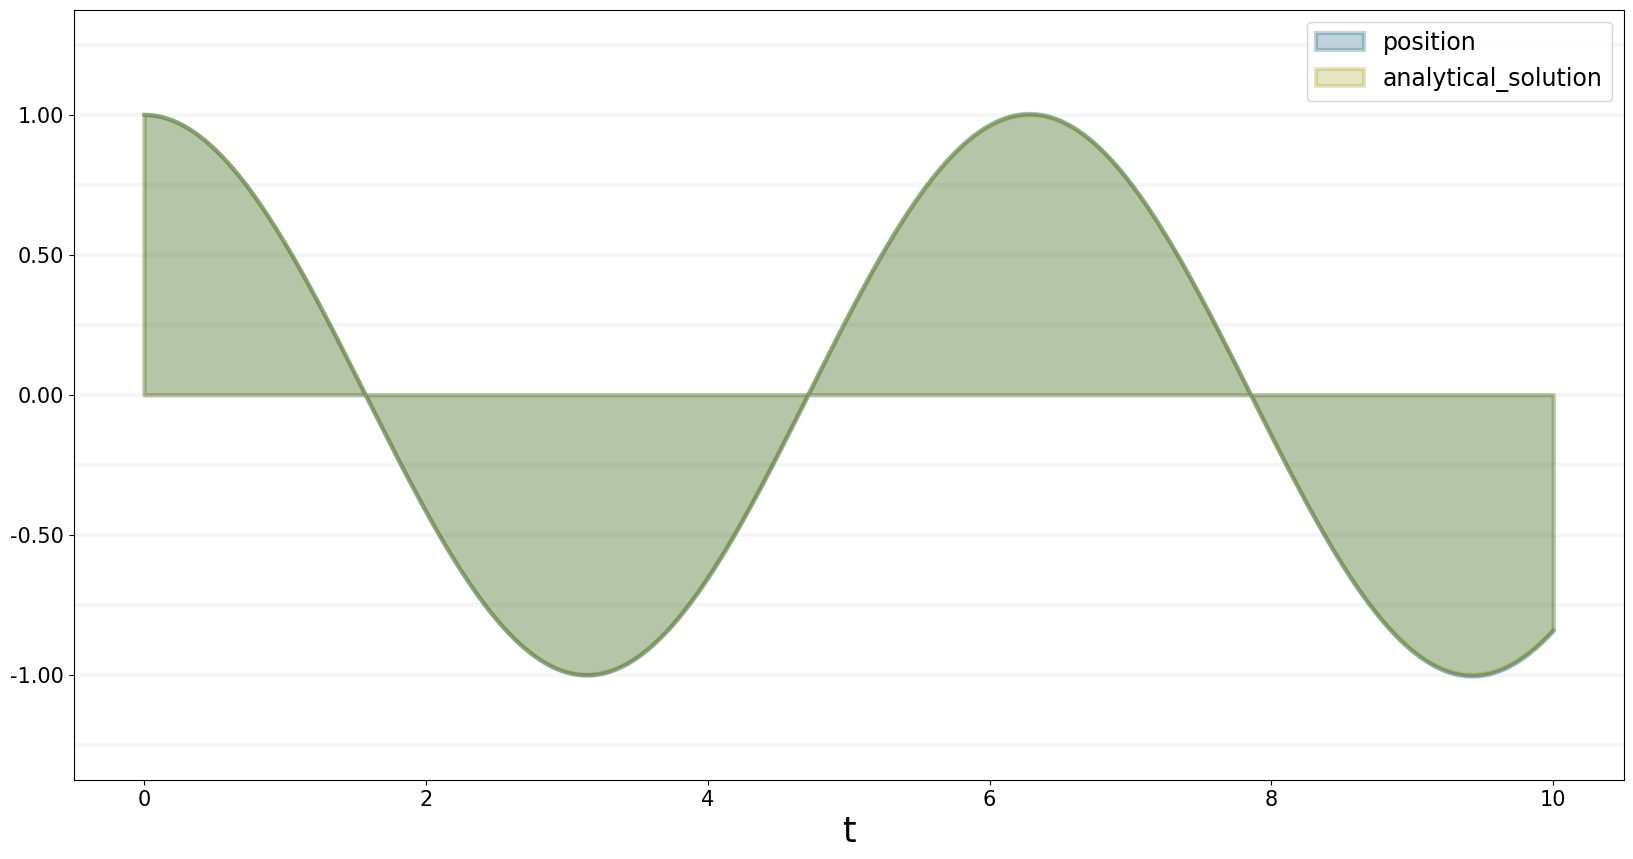

In [7]:
bptk.plot_scenarios(
    scenario_managers=["smOscillator"],
    scenarios=["base"],
    equations=["position","analytical_solution"])

The numerical solution is quite precise (and the precision can be increased further by decreasing dt) - you can see nicely in the following graph that the error increases over time:

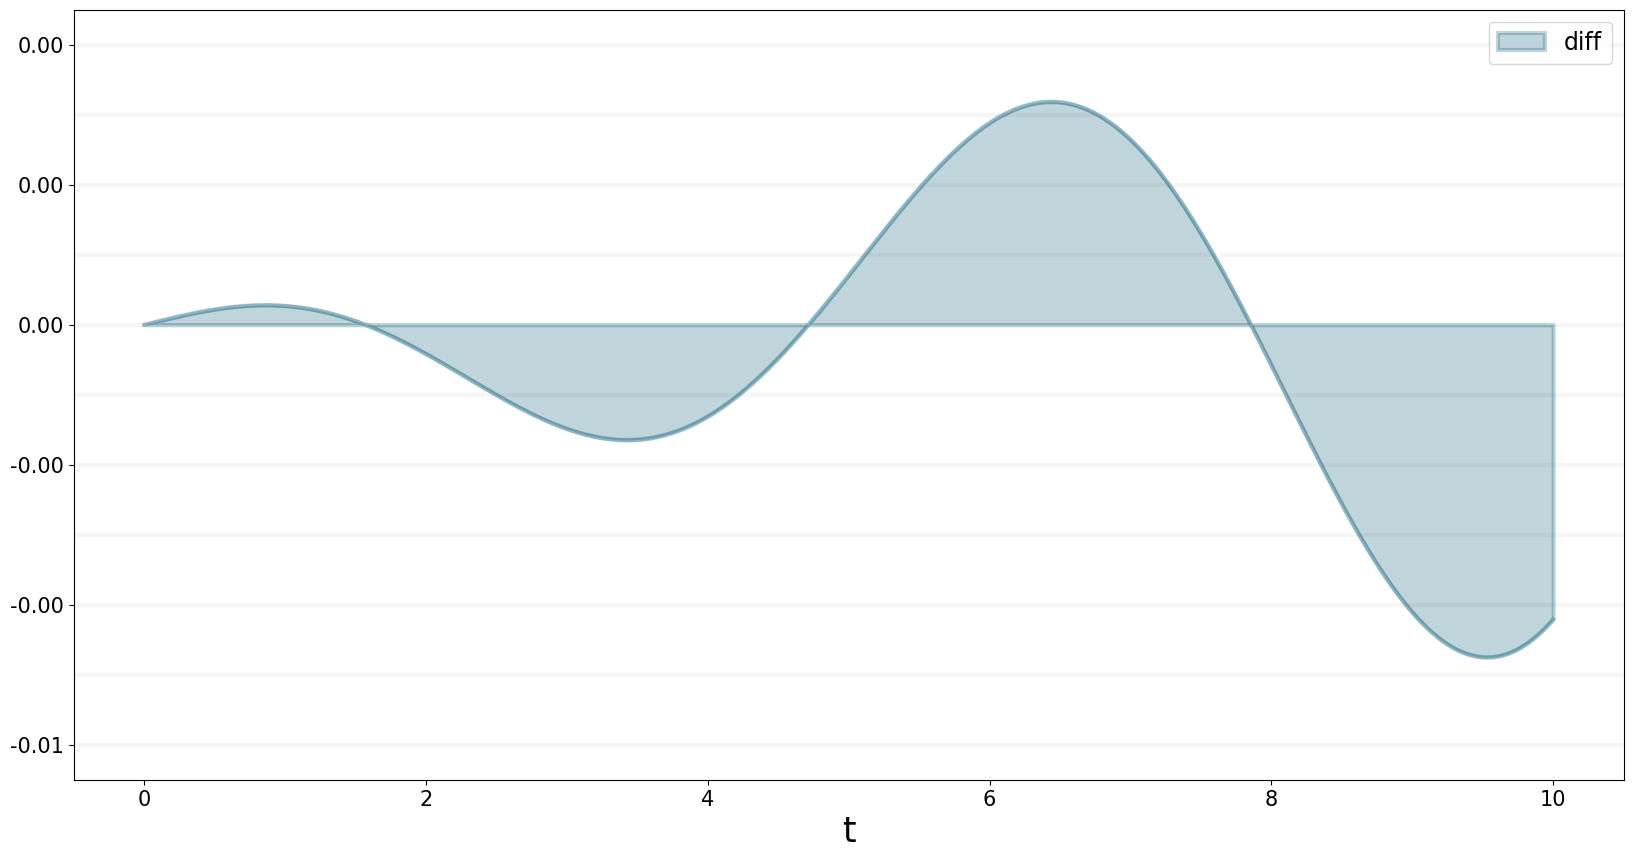

In [8]:
bptk.plot_scenarios(
    scenario_managers=["smOscillator"],
    scenarios=["base"],
    equations=["diff"])

In [9]:
df = bptk.plot_scenarios(
    scenario_managers=["smOscillator"],
    scenarios=["base"],
    equations=["diff"],return_df=True)

There are no erros greater than 0.004:

In [10]:
df[df["diff"] > 0.004]

,diff
t,


But 672 out of 10,000 errors > 0.003:

In [11]:
df[df["diff"] > 0.003]

,diff
t,
6.097,0.003000
6.098,0.003001
6.099,0.003002
6.100,0.003003
6.101,0.003004
...,...
6.764,0.003005
6.765,0.003004
6.766,0.003002
